In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

/Users/giadarol/xsuite_packages/xtrack/xtrack/progress_indicator.py:95: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
line = xt.Line.from_json('pimms_00_optics.json')
line.configure_bend_model(edge='full', core='adaptive', num_multipole_kicks=10)

Loading line from dict:   0%|          | 0/220 [00:00<?, ?it/s]

Done loading line from dict.           


In [4]:
line.insert_element(
            'septum_aperture',
            xt.LimitRect(min_x=-0.1, max_x=0.1, min_y=-0.1, max_y=0.1),
            index='extr_septum')
line.build_tracker()

Found suitable prebuilt kernel `default_only_xtrack`.


In [5]:
line.vars['kse1'] = 1
line.vars['kse2'] = -6.5

In [6]:
from phase_space_characterization import characterize_phase_space_at_septum

In [7]:
%time characterize_phase_space_at_septum(line, num_turns=1000)

Found suitable prebuilt kernel `only_xtrack_frozen_energy`.
CPU times: user 855 ms, sys: 2.66 s, total: 3.51 s
Wall time: 367 ms


{'dpx_dx_at_septum': -0.03441048400154095,
 'stable_area': 6.505621653827881e-05,
 'x_fp': array([-0.01050488, -0.00441164,  0.01403217]),
 'px_fp': array([-0.01050488, -0.00441164,  0.01403217]),
 'x_norm_fp': array([-0.00357558, -0.0015016 ,  0.00477618]),
 'px_norm_fp': array([-0.00357558, -0.0015016 ,  0.00477618])}

<IPython.core.display.Javascript object>


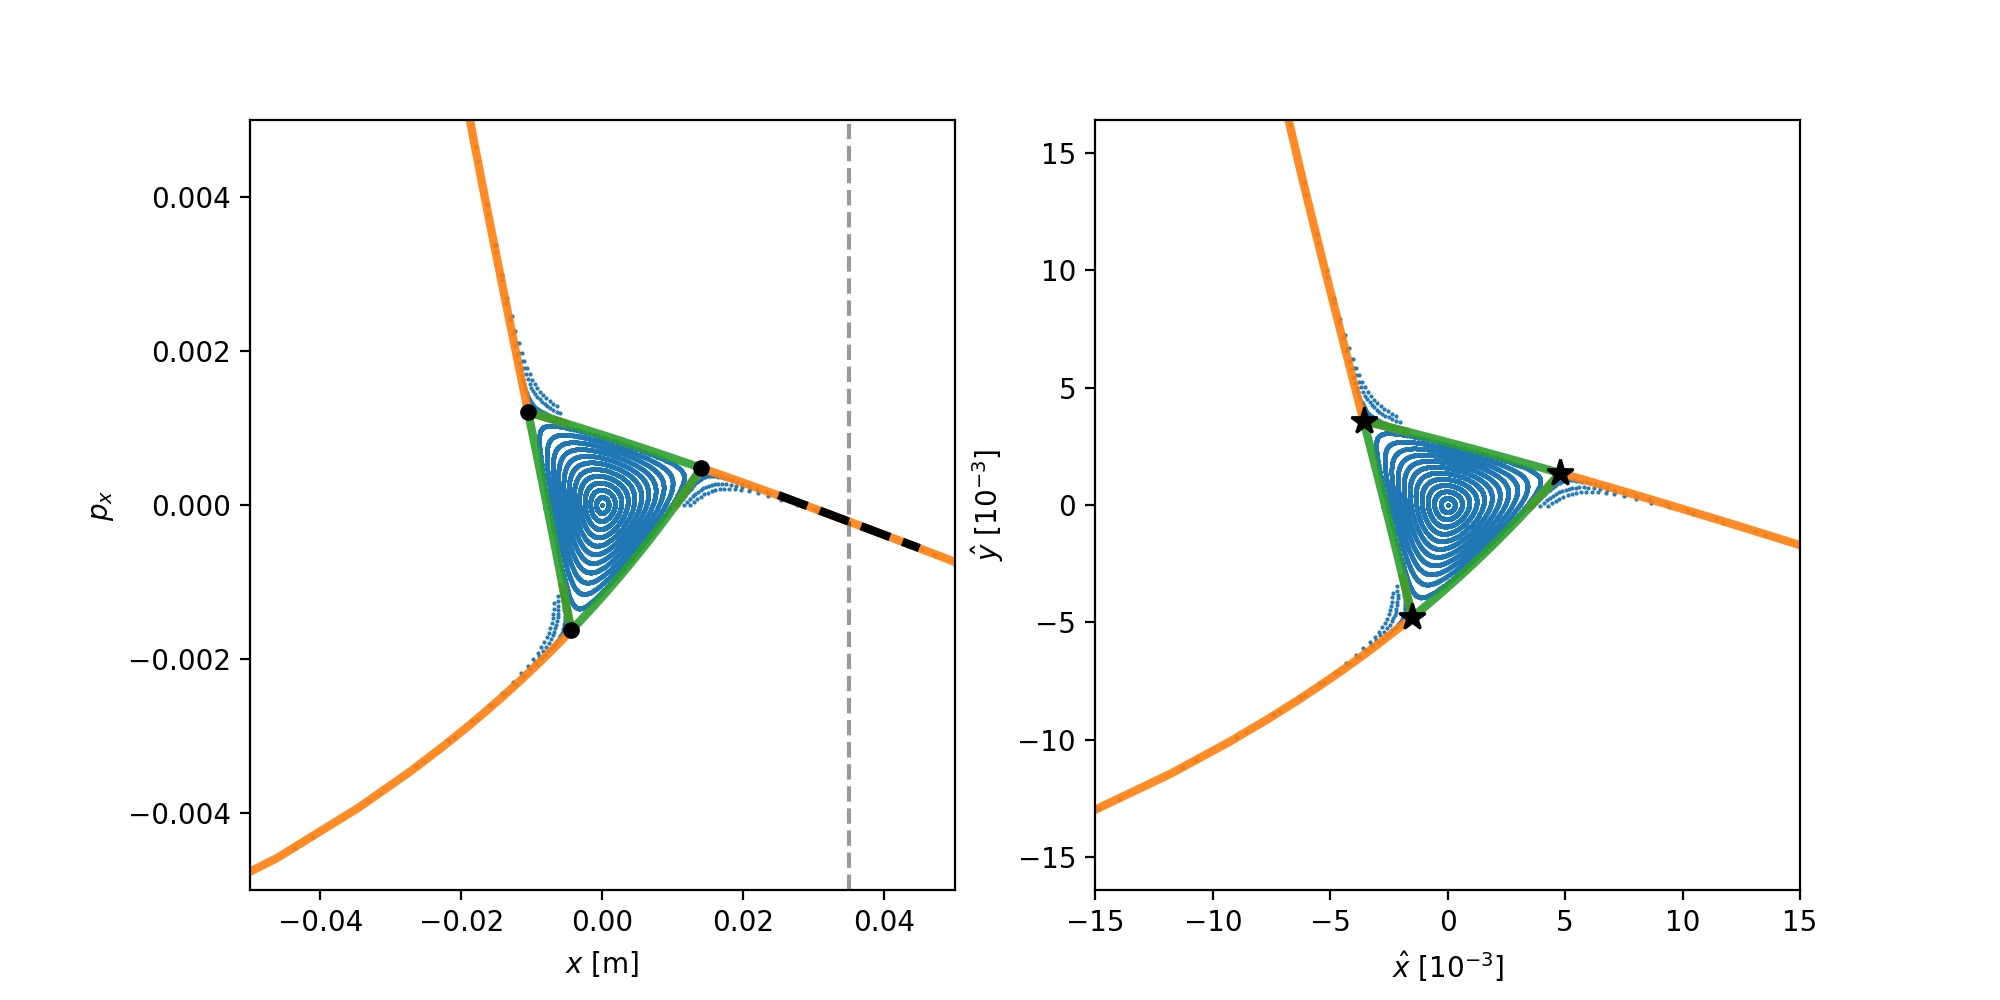

{'dpx_dx_at_septum': -0.03441048400154095,
 'stable_area': 6.505621653827881e-05,
 'x_fp': array([-0.01050488, -0.00441164,  0.01403217]),
 'px_fp': array([-0.01050488, -0.00441164,  0.01403217]),
 'x_norm_fp': array([-0.00357558, -0.0015016 ,  0.00477618]),
 'px_norm_fp': array([-0.00357558, -0.0015016 ,  0.00477618])}

In [8]:
characterize_phase_space_at_septum(line, num_turns=1000, plot=True)

In [10]:
class ActionSeparatrix(xt.Action):
    
    def __init__(self, line):
        self.line = line
        
    def run(self):
        out = characterize_phase_space_at_septum(self.line)
        return out

In [ ]:
action = ActionSeparatrix(line)

In [ ]:
action.run()

In [ ]:
opt = line.match(
    solve=False,
    method='4d',
    vary=xt.VaryList(['kse1', 'kse2'], step=0.5, limits=[-7, 7]),
    targets=[
        action.target('stable_area', 1.e-4, tol=1e-5, weight=100), 
        action.target('dpx_dx_at_septum', 0.03, tol=5e-4)
    ]
)

In [ ]:
opt.target_status()

In [ ]:
def err_fun(x):
    out = opt._err(x, check_limits=False)
    #print(f'x = {repr(x)}, out = {out}')
    return out

bounds = np.array([vv.limits for vv in opt._err.vary])
opt._err.return_scalar = True
import pybobyqa
soln = pybobyqa.solve(err_fun, x0=opt.log().vary[0, :], bounds=bounds.T,
            rhobeg=5, rhoend=1e-4, maxfun=30, objfun_has_noise=True,
            seek_global_minimum=True)
err_fun(soln.x) # set it to found solution
opt.tag('pybobyqa') # Add point to optimization log
opt.target_status()

In [ ]:
opt.log()

In [ ]:
opt.vary_status()

In [ ]:
characterize_phase_space_at_septum(line, num_turns=1000, plot=True)

In [ ]:
line.to_json('pimms_02_tuned.json')